In [18]:
from dataloader import read_bci_data
import torch
import sys
import torch.nn as nn
import matplotlib.pyplot as plt

from torchsummary import summary
from torch .utils.data import TensorDataset,DataLoader
import torch.nn.functional as F
import numpy as np
EPOCHS=30
#BATCH_SIZE=256
train_data, train_label, test_data, test_label=read_bci_data()
test_dataset = TensorDataset (torch.Tensor(test_data) , torch.Tensor(test_label))
test_loader=DataLoader(test_dataset,batch_size=1080)
trian_dataset=TensorDataset(torch.Tensor(train_data),torch.Tensor(train_label))#資料要是tensor的形式
loader64 =DataLoader(
    dataset=trian_dataset,
    batch_size=64,
    shuffle=True,
)
loader128 =DataLoader(
    dataset=trian_dataset,
    batch_size=128,
    shuffle=True,
)
loader256 =DataLoader(
    dataset=trian_dataset,
    batch_size=256,
    shuffle=True,
)
loader1080 =DataLoader(
    dataset=trian_dataset,
    batch_size=1080,
)

class EEGNet(nn.Module):
    def __init__(self, name,activation: nn.modules.activation,dropoutparameter=0.25):
        super().__init__()
        self.name=name
        self.firstconv=nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1,51),stride=(1,1),padding=(0,25),bias =True),
            nn.BatchNorm2d(16,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True)   
        )
        self.depthwiseConv=nn.Sequential(
            nn.Conv2d(16,32,kernel_size=(2,1),stride=(1,1),groups=16,bias=True),
            nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
            nn.Dropout(p=dropoutparameter))
        self.separableconv=nn.Sequential(
            nn.Conv2d(32,32,kernel_size=(1,15),stride=(1,1),padding=(0,7), bias=True),
            nn.BatchNorm2d(32,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            activation(),
            nn.AvgPool2d(kernel_size=(1,8),stride=(1,8),padding=0),
            nn.Dropout(p=dropoutparameter)
            )
        self.classify=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=736,out_features=2,bias=True),
        )
    def forward(self,input):
        out=self.firstconv(input)
        out=self.depthwiseConv(out)
        out=self.separableconv(out)
        out=self.classify(out)
        return out
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EEGELU=EEGNet('EEGELU',nn.ELU).to(device)
EEGRELU=EEGNet('EEGRELU',nn.ReLU).to(device)
EEGLeakyrelu=EEGNet('EEGLeakyrelu',nn.LeakyReLU).to(device)


    

In [19]:
def training(model,epochs=EPOCHS,lr=0.001):
    model=model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)
    
    loss_func=nn.CrossEntropyLoss()
    n_total_steps = len(loader128)
    error_list=[]
    test_acc=[]
    train_acc=[]
    test_acc.append(test_accuracy(model))
    train_acc.append(train_accuracy(model))
    for epoch in range (epochs):
        for step,(train,label) in enumerate(loader128):
            train=train.to(device)
            label=label.to(device).long()#這邊這個long不知道是幹嘛的
            outputs =model.forward(train)
            loss =loss_func(outputs,label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            print(f' epoch {epoch+1}, iteration {step+1}/{n_total_steps}, loss = {loss.item():.4f}')
        
        error_list.append(loss)
        test_acc.append(test_accuracy(model))
        train_acc.append(train_accuracy(model))
    
    for i in range(epochs):
        error_list[i]=error_list[i].item()

    return error_list,train_acc,test_acc,max(test_acc),np.argmax(test_acc)

def test_accuracy(model,printbool=False):
    with torch.no_grad():
        for data,target in test_loader:
            data,target =data.to(device),target.to(device)
            outputs=model(data)
            target=torch.reshape(target,(1080,1))
            pred =outputs.argmax (dim=1,keepdim=True)
    return len(pred[(pred==target)])/1080*100
def train_accuracy(model,printbool=False):
    with torch.no_grad():
        for data,target in loader1080:
            data,target =data.to(device),target.to(device)
            outputs=model(data)
            target=torch.reshape(target,(1080,1))
            pred =outputs.argmax (dim=1,keepdim=True)
    return len(pred[(pred==target)])/1080*100  

In [20]:
errl1,train_accl1,test_acc1,maxacc1,index1=training(EEGRELU)
errl2,train_accl2,test_acc2,maxacc2,index2=training(EEGLeakyrelu)
errl3,train_accl3,test_acc3,maxacc3,index3=training(EEGELU)

 epoch 1, iteration 1/9, loss = 0.6898
 epoch 1, iteration 2/9, loss = 0.6956
 epoch 1, iteration 3/9, loss = 0.6548
 epoch 1, iteration 4/9, loss = 0.6693
 epoch 1, iteration 5/9, loss = 0.6462
 epoch 1, iteration 6/9, loss = 0.6511
 epoch 1, iteration 7/9, loss = 0.5804
 epoch 1, iteration 8/9, loss = 0.6098
 epoch 1, iteration 9/9, loss = 0.6590
 epoch 2, iteration 1/9, loss = 0.5765
 epoch 2, iteration 2/9, loss = 0.5679
 epoch 2, iteration 3/9, loss = 0.5652
 epoch 2, iteration 4/9, loss = 0.5015
 epoch 2, iteration 5/9, loss = 0.5969
 epoch 2, iteration 6/9, loss = 0.5670
 epoch 2, iteration 7/9, loss = 0.6165
 epoch 2, iteration 8/9, loss = 0.5681
 epoch 2, iteration 9/9, loss = 0.5205
 epoch 3, iteration 1/9, loss = 0.5129
 epoch 3, iteration 2/9, loss = 0.5260
 epoch 3, iteration 3/9, loss = 0.4625
 epoch 3, iteration 4/9, loss = 0.6030
 epoch 3, iteration 5/9, loss = 0.5519
 epoch 3, iteration 6/9, loss = 0.4777
 epoch 3, iteration 7/9, loss = 0.5387
 epoch 3, iteration 8/9, 

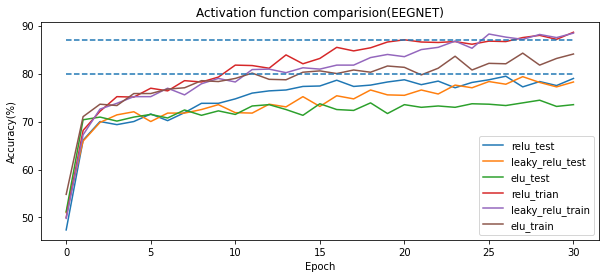

最高準確率: 79.44444444444444 % 發生在epoch: 27


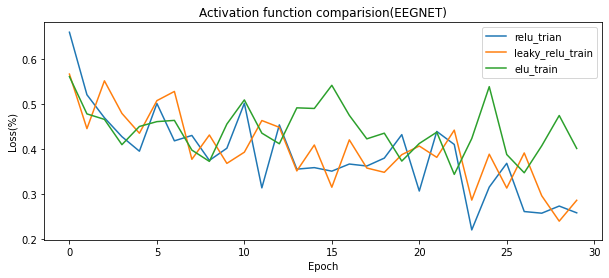

79.44444444444444
79.35185185185185
74.44444444444444


In [21]:
plt.figure(figsize=(10,4))
plt.plot(range(EPOCHS+1),test_acc1,label="relu_test")
plt.plot(range(EPOCHS+1),test_acc2,label="leaky_relu_test")
plt.plot(range(EPOCHS+1),test_acc3,label="elu_test")
plt.plot(range(EPOCHS+1),train_accl1,label="relu_trian")
plt.plot(range(EPOCHS+1),train_accl2,label="leaky_relu_train")
plt.plot(range(EPOCHS+1),train_accl3,label="elu_train")
plt.hlines(y=87,xmin=0, xmax=EPOCHS,linestyle="--")
plt.hlines(y=80,xmin=0, xmax=EPOCHS,linestyle="--")
plt.legend()
plt.title('Activation function comparision(EEGNET)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.show()
print("最高準確率:",max(maxacc1,maxacc2,maxacc3),"%",'發生在epoch:',index2)
plt.figure(figsize=(10,4))
plt.plot(range(EPOCHS),errl1,label="relu_trian")
plt.plot(range(EPOCHS),errl2,label="leaky_relu_train")
plt.plot(range(EPOCHS),errl3,label="elu_train")

plt.legend()
plt.title('Activation function comparision(EEGNET)')
plt.xlabel('Epoch')
plt.ylabel('Loss(%)')
plt.show()
print(maxacc1)
print(maxacc2)
print(maxacc3)

In [7]:
class DeepConvNet(nn.Module):
    def __init__(self,activation):
        super().__init__()
        self.firstconv=nn.Sequential(
            nn.Conv2d(1,25 ,kernel_size=(1,5),stride=(1,1)),
            nn.Conv2d(25,25,kernel_size=(2,1),stride=(1,1)),
            nn.BatchNorm2d(25,eps=1e-05,momentum=0.1,affine=True,track_running_stats=True),
            activation(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),
            nn.Conv2d(25,50,kernel_size=(1,5),stride=(1,1),bias=True),
            nn.BatchNorm2d(50,eps=1e-05,momentum=0.1),
            activation(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(p=0.5),
            nn.Conv2d(50,100,kernel_size=(1,5),stride=(1,1)),
            nn.BatchNorm2d(100,eps=1e-05,momentum=0.1),
            activation(),
            nn.MaxPool2d(kernel_size=(1,2)),
            nn.Dropout(0.5),
            nn.Conv2d(100,200,kernel_size=(1,5),stride=(1,1)),
            nn.BatchNorm2d(200,eps=1e-05,momentum=0.1),
            activation(),
            nn.MaxPool2d((1,2)),
            nn.Dropout(0.5),
            nn.Flatten(),
            nn.Linear(8600,2),      
        )
    def forward(self,input):
        out=self.firstconv(input)
        return out

        
deeprelu=DeepConvNet(nn.ReLU).to(device)
deepleakyrelu=DeepConvNet(nn.LeakyReLU).to(device)
deepELU=DeepConvNet(nn.ELU).to(device)

In [8]:
deeperr1,deeptrain1,deeptest1,deepmax1,deepindex1= training(deeprelu)
deeperr2,deeptrain2,deeptest2,deepmax2,deepindex2=training(deepleakyrelu)
deeperr3,deeptrain3,deeptest3,deepmax3,deepindex3=training(deepELU)

 epoch 1, iteration 1/9, loss = 0.9113
 epoch 1, iteration 2/9, loss = 4.0954
 epoch 1, iteration 3/9, loss = 2.5621
 epoch 1, iteration 4/9, loss = 0.8441
 epoch 1, iteration 5/9, loss = 2.2389
 epoch 1, iteration 6/9, loss = 1.6775
 epoch 1, iteration 7/9, loss = 0.8279
 epoch 1, iteration 8/9, loss = 1.3022
 epoch 1, iteration 9/9, loss = 1.5196
 epoch 2, iteration 1/9, loss = 0.8836
 epoch 2, iteration 2/9, loss = 0.7444
 epoch 2, iteration 3/9, loss = 0.8659
 epoch 2, iteration 4/9, loss = 0.8636
 epoch 2, iteration 5/9, loss = 1.0417
 epoch 2, iteration 6/9, loss = 0.7676
 epoch 2, iteration 7/9, loss = 0.7299
 epoch 2, iteration 8/9, loss = 0.9557
 epoch 2, iteration 9/9, loss = 1.0336
 epoch 3, iteration 1/9, loss = 0.7647
 epoch 3, iteration 2/9, loss = 0.7229
 epoch 3, iteration 3/9, loss = 0.8492
 epoch 3, iteration 4/9, loss = 0.7146
 epoch 3, iteration 5/9, loss = 0.7285
 epoch 3, iteration 6/9, loss = 0.7167
 epoch 3, iteration 7/9, loss = 0.6014
 epoch 3, iteration 8/9, 

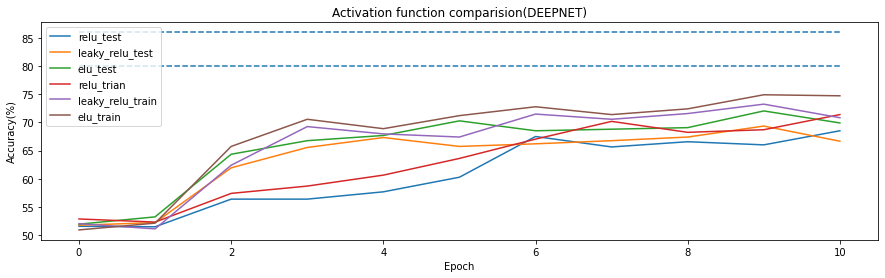

最高準確率: 72.03703703703704 % 發生在epoch: 9


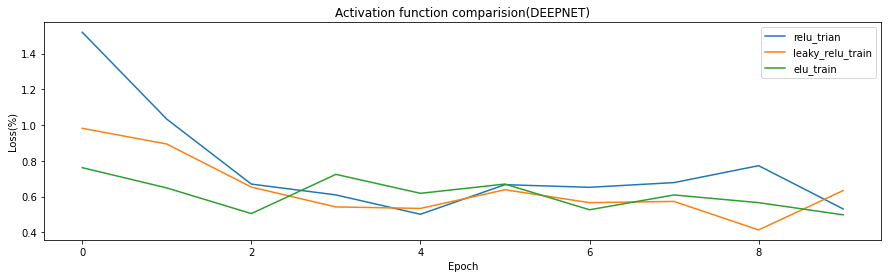

In [9]:
plt.figure(figsize=(15,4))
plt.plot(range(EPOCHS+1),deeptest1,label="relu_test")
plt.plot(range(EPOCHS+1),deeptest2,label="leaky_relu_test")
plt.plot(range(EPOCHS+1),deeptest3,label="elu_test")
plt.plot(range(EPOCHS+1),deeptrain1,label="relu_trian")
plt.plot(range(EPOCHS+1),deeptrain2,label="leaky_relu_train")
plt.plot(range(EPOCHS+1),deeptrain3,label="elu_train")
plt.hlines(y=80,xmin=0,xmax=EPOCHS,linestyles='--')
plt.hlines(y=86,xmin=0,xmax=EPOCHS,linestyles='--')
plt.legend()
plt.title('Activation function comparision(DEEPNET)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.show()
print("最高準確率:",max(deepmax1,deepmax2,deepmax3),"%",'發生在epoch:',deepindex3)
plt.figure(figsize=(15,4))
plt.plot(range(EPOCHS),deeperr1,label="relu_trian")
plt.plot(range(EPOCHS),deeperr2,label="leaky_relu_train")
plt.plot(range(EPOCHS),deeperr3,label="elu_train")
plt.legend()
plt.title('Activation function comparision(DEEPNET)')
plt.xlabel('Epoch')
plt.ylabel('Loss(%)')
plt.show()
